In [104]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", palette="muted", font_scale=1.5)
import holidays
us_holidays = holidays.US()

# 1
## Data Preprocessing

First, we load the raw data and get rid of some of the columns. We only care about price, so we include that. Percent change is recalculated as log (to ensure no error in data).

We might predict on percent change due to benefit of stationarity for time series models.

In [105]:
raw_data = pd.read_csv('data/raw_data.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data = raw_data.sort_values(by='Date')

# drop volume
raw_data = raw_data.drop(columns=['Vol.'])

# from what is discussed, we only care about "price". Open, High, Low, and Change % will be dropped as well
raw_data = raw_data.drop(columns=['Open', 'High', 'Low', 'Change %'])

raw_data['LogPercentChange'] = np.log(raw_data['Price'] / raw_data['Price'].shift(1))
raw_data = raw_data.iloc[1:,:].reset_index(drop=True)

# Show the resulting data
display(raw_data.head())

,Date,Price,LogPercentChange
0,2007-12-04,498.519,-0.011147
1,2007-12-05,493.834,-0.009442
2,2007-12-06,509.300,0.030838
3,2007-12-07,498.294,-0.021847
4,2007-12-10,496.023,-0.004568


## Graphing

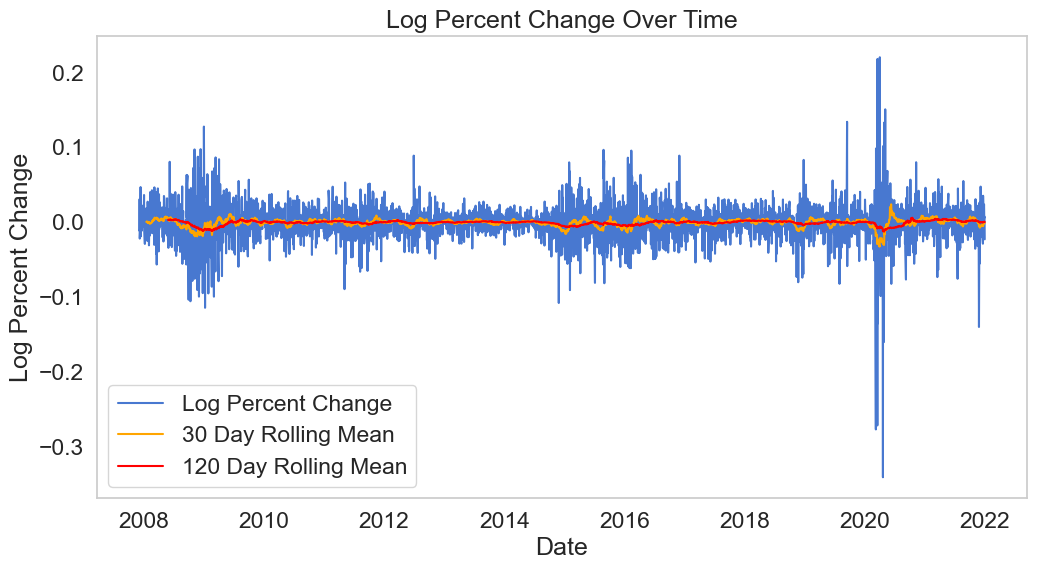

In [106]:
# plot LogPercentChange
plt.figure(figsize=(12, 6))
plt.plot(raw_data['Date'], raw_data['LogPercentChange'], label='Log Percent Change')
# plot rolling mean 30 days and 120 days
plt.plot(raw_data['Date'], raw_data['LogPercentChange'].rolling(30).mean(), label='30 Day Rolling Mean', color='orange')
plt.plot(raw_data['Date'], raw_data['LogPercentChange'].rolling(120).mean(), label='120 Day Rolling Mean', color='red')
plt.title('Log Percent Change Over Time')
plt.xlabel('Date')
plt.ylabel('Log Percent Change')
plt.legend()
plt.grid()
plt.show()


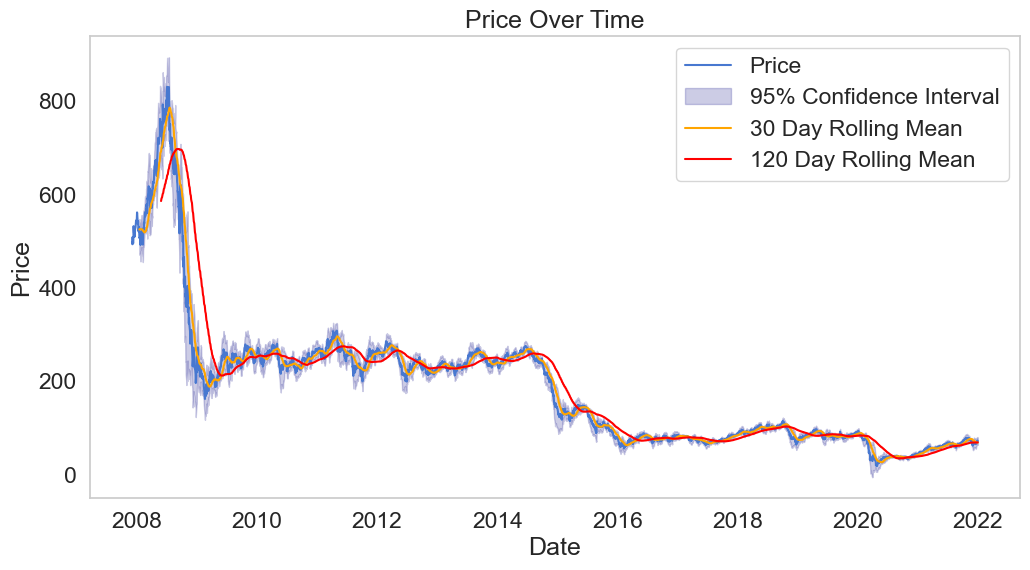

In [107]:
# Let's also plot the price
plt.figure(figsize=(12, 6))
plt.plot(raw_data['Date'], raw_data['Price'], label='Price')
# plot 95% confidence interval
plt.fill_between(raw_data['Date'], raw_data['Price'] - 1.96 * raw_data['Price'].rolling(30).std(),
                 raw_data['Price'] + 1.96 * raw_data['Price'].rolling(30).std(), color='navy', alpha=0.2,
                 label='95% Confidence Interval')

# plot rolling mean 30 days and 120 days
plt.plot(raw_data['Date'], raw_data['Price'].rolling(30).mean(), label='30 Day Rolling Mean', color='orange')
plt.plot(raw_data['Date'], raw_data['Price'].rolling(120).mean(), label='120 Day Rolling Mean', color='red')

plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


# 2
## Setting the Scene

Let's setup our error function, split our data how we will want to train and test.

Training is from January 2, 2008 to August 4, 2017.
Test is remaining.

We split cross valdiation from Jan 2 to Aug 4 into 5 folds.

In [108]:
# loss function we care about
def MAPE_squared(y_true, y_pred):
    # add small noise to y_true to avoid division by zero
    y_true = y_true + 1e-10
    return np.mean(np.abs((y_true - y_pred) / y_true) ** 2)

def SMAPE_squared(y_true, y_pred):
    # add small noise to y_true and y_pred to avoid division by zero
    y_true = y_true + 1e-10
    y_pred = y_pred + 1e-10
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) ** 2)

# split up the data for cross validation
# this will be done via a function, since we will need to do this multiple times
# and it will be different for each model

def kfold_split(X, y, k=5):
    # this will return k folds of the data split for time series
    # so, in total, the data will be split into k + 1 parts
    # the first fold will consist of the first 1/(k+1) of the data as train, and the next 1/(k+1) as test
    # the second fold will consist of the first 2/(k+1) of the data as train, and the next 1/(k+1) as test
    # and so on
    splits = {
        'train_X': [],
        'train_y': [],
        'val_X': [],
        'val_y': []
    }

    for i in range(k):
        # train data will be the first i/(k+1) of the data
        # val data will be the next 1/(k+1) of the data
        train_X = X[:int((i + 1) / (k + 1) * len(X))]
        train_y = y[:int((i + 1) / (k + 1) * len(y))]
        val_X = X[int((i + 1) / (k + 1) * len(X)):int((i + 2) / (k + 1) * len(X))]
        val_y = y[int((i + 1) / (k + 1) * len(y)):int((i + 2) / (k + 1) * len(y))]

        splits['train_X'].append(train_X)
        splits['train_y'].append(train_y)
        splits['val_X'].append(val_X)
        splits['val_y'].append(val_y)
    return splits

# 3
## Supervised Classical Machine Learning with Regularization
### (Boosting via XGBoost)

So, since we are not yet in the time-series world, we want need to capture essence of the nature of data via feature engineering.

In [109]:
df = raw_data.copy()

# we start with Jan 2, 2008
# training set ends at Aug 4, 2017
training_df = df[(df['Date'] <= '2017-08-04') & (df['Date'] >= '2008-01-02')]
test_df = df[df['Date'] > '2017-08-04']

# check for missing values
print("Missing values in training set:")
print(training_df.isnull().sum())
print("Missing values in test set:")
print(test_df.isnull().sum())

def preprocess_xgboost(df, lags = [1, 2, 3, 4, 5, 15]):
    df = df.copy()
    # split date into year, month, day of week
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    # check for holidays
    df['IsHoliday'] =df['Date'].isin(us_holidays)
    if not df['IsHoliday'].any():
        # print("No holidays in the data")
        df = df.drop(columns=['IsHoliday'])

    # check for weekends
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])
    if not df['IsWeekend'].any():
        # print("No weekends in the data")
        df = df.drop(columns=['IsWeekend'])

    # add cyclical features

    # this helps the model tell which month it is
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # then this tells where it is in the half of the year
    df['Month_sin_6'] = np.sin(2 * np.pi * df['Month'] / 6)
    df['Month_cos_6'] = np.cos(2 * np.pi * df['Month'] / 6)

    # then this tells where it is in the quarter of the year
    df['Month_sin_4'] = np.sin(2 * np.pi * df['Month'] / 4)
    df['Month_cos_4'] = np.cos(2 * np.pi * df['Month'] / 4)

    # day of week: add cyclic features for every 7 days
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_sin_3'] = np.sin(2 * np.pi * df['DayOfWeek'] / 3)
    df['DayOfWeek_cos_3'] = np.cos(2 * np.pi * df['DayOfWeek'] / 3)
    df['DayOfWeek_sin_2'] = np.sin(2 * np.pi * df['DayOfWeek'] / 2)
    df['DayOfWeek_cos_2'] = np.cos(2 * np.pi * df['DayOfWeek'] / 2)

    # add cyclic features for the year based on the year
    # for now, assume a 3 year cycle and a 2 year cycle
    df['Year_sin_3'] = np.sin(2 * np.pi * (df['Year'] % 3)/3)
    df['Year_cos_3'] = np.cos(2 * np.pi * (df['Year'] % 3)/3)
    df['Year_sin_2'] = np.sin(2 * np.pi * (df['Year'] % 2)/2)
    df['Year_cos_2'] = np.cos(2 * np.pi * (df['Year'] % 2)/2)

    # drop the original features
    df = df.drop(columns=['Year', 'Month', 'DayOfWeek'])

    # add lag features
    # lag for 1,2,3,4,5,15 days
    for lag in lags:
        df['Lag_' + str(lag)] = df['Price'].shift(lag)

    # due to lag, we need to drop rows with NaN values
    df = df.dropna()

    return df

training_df_processed = preprocess_xgboost(training_df)
test_df_processed = preprocess_xgboost(test_df)

X_train, y_train = training_df_processed.drop(columns=['LogPercentChange', 'Date', 'Price']), training_df_processed['Price']
X_test, y_test = test_df_processed.drop(columns=['LogPercentChange', 'Date', 'Price']), test_df_processed['Price']


Missing values in training set:
Date                0
Price               0
LogPercentChange    0
dtype: int64
Missing values in test set:
Date                0
Price               0
LogPercentChange    0
dtype: int64


# 3.1
## Fitting the Model

In [110]:
kfolds = kfold_split(X_train, y_train, k=5)

/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_35226/3306683124.py:34: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_y = y[:int((i + 1) / (k + 1) * len(y))]
/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_35226/3306683124.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  val_y = y[int((i + 1) / (k + 1) * len(y)):int((i + 2) / (k + 1) * len(y))]


In [157]:
import numpy as np
from sklearn.model_selection import BaseCrossValidator, GridSearchCV
from xgboost import XGBRegressor
import tqdm


kfolds = kfold_split(X_train, y_train, k=5)

param_grid = {
    'n_estimators':     [500, 1000, 1250, 1500, 2000, 2500],
    'learning_rate':    [0.01, 0.05, 0.1],
    'max_depth':        [3, 5, 7],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha':        [0, 0.1, 1],
    'reg_lambda':       [1, 5, 10],
}


model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mape',
    tree_method='hist',
    random_state=42,
)

# number of iterations to run
iters = 500

np.random.seed(195)

# create a list to store the results
results = []

for _ in tqdm.tqdm(range(iters)):
    # get a random sample of params
    params = {k: np.random.choice(v) for k, v in param_grid.items()}

    model = XGBRegressor(
        objective='reg:squarederror', # i tried implementing training via MAPE but ran into kernel errors
        eval_metric='mape',
        tree_method='hist',
        random_state=195,
        **params
    )

    cv_results = []

    # fit on each fold and evaluate
    for i in range(len(kfolds['train_X'])):
        train_X = kfolds['train_X'][i]
        train_y = kfolds['train_y'][i]
        val_X = kfolds['val_X'][i]
        val_y = kfolds['val_y'][i]

        model.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)
        y_pred = model.predict(val_X)

        # calculate MAPE
        mape = MAPE_squared(val_y, y_pred)
        cv_results.append(mape)

    # calculate the mean and std of the MAPE
    mean_mape = np.mean(cv_results)
    std_mape = np.std(cv_results)
    # append the results
    results.append({
        'params': params,
        'mean_mape': mean_mape,
        'std_mape': std_mape
    })
# sort the results by mean_mape
results = sorted(results, key=lambda x: x['mean_mape'])

# find the lowest mean_mape
best_result = results[0]
print("Best result:")
print("Params: ", best_result['params'])
# write result to txt file
with open('best_result_xgboost.txt', 'w+') as f:
    f.write(str(best_result))
print("Mean MAPE: ", best_result['mean_mape'])
print("Std MAPE: ", best_result['std_mape'])



/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_35226/3306683124.py:34: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_y = y[:int((i + 1) / (k + 1) * len(y))]
/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_35226/3306683124.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  val_y = y[int((i + 1) / (k + 1) * len(y)):int((i + 2) / (k + 1) * len(y))]
100%|██████████| 500/500 [1:57:09<00:00, 14.06s/it]  

Best result:
Params:  {'n_estimators': 1500, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 10}
Mean MAPE:  0.0555191661684987
Std MAPE:  0.1007981423577881


Test MAPE:  0.14782163327921866


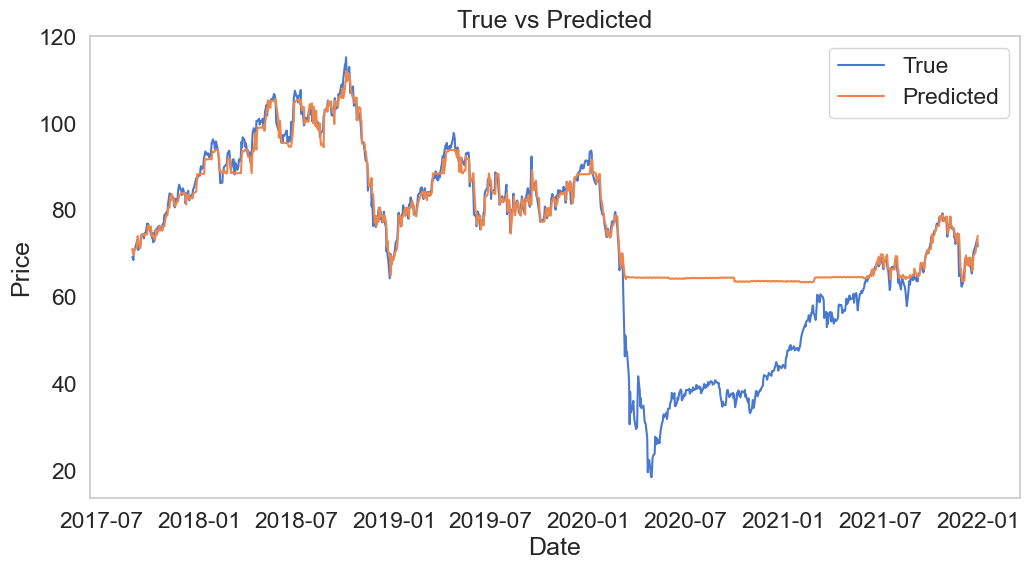

In [158]:
# fit model with best results
best_params = best_result['params']
model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mape',
    tree_method='hist',
    random_state=195,
    **best_params
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = model.predict(X_test)

# calculate MAPE
mape = MAPE_squared(y_test, y_pred)

print("Test MAPE: ", mape)

# plot the results
plt.figure(figsize=(12, 6))

plt.plot(test_df_processed['Date'], y_test, label='True')
plt.plot(test_df_processed['Date'], y_pred, label='Predicted')
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


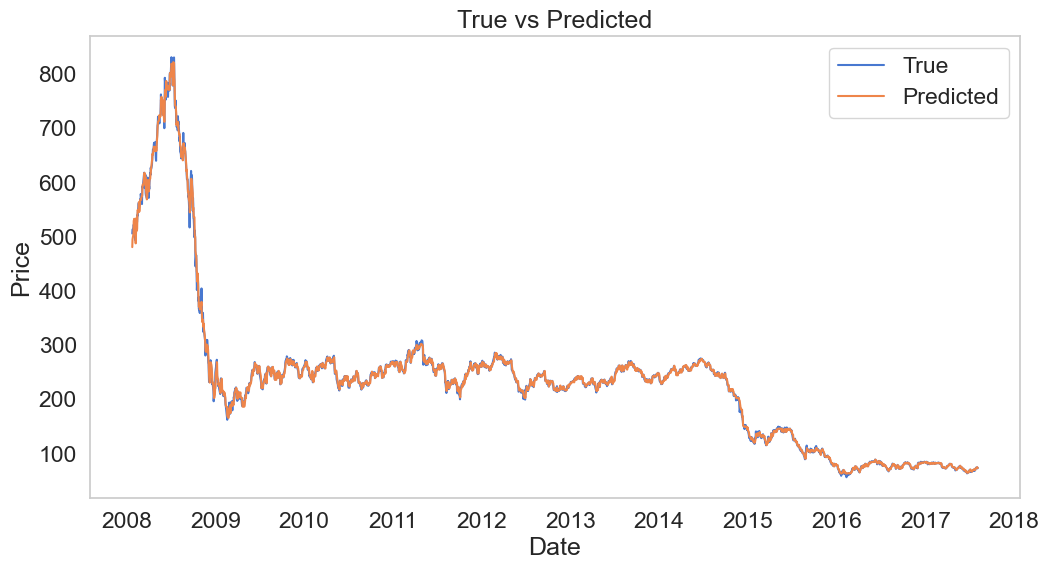

In [159]:
# plot training results of price
plt.figure(figsize=(12, 6))
plt.plot(training_df_processed['Date'], y_train, label='True')
plt.plot(training_df_processed['Date'], model.predict(X_train), label='Predicted')
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

Of course, this isn't too useful. Predicting the previous day's price will almost always be the best option. Instead, we want to test forecasting capabilities.

To do this, we have to create a function that recursively feeds information back into the model.

In [130]:
full_df = pd.concat([training_df, test_df], axis=0)

# just to make sure it is sorted by date
full_df = full_df.sort_values(by='Date').reset_index(drop=True)


def predict_date_forecast(df, model, date, horizon, lags = [1, 2, 3, 4, 5, 15]):
    '''
    Predicts the price for a given date, but the model can only see the data up to
    the date minus the horizon.
    '''
    df = df.copy()
    df = preprocess_xgboost(df, lags=[])

    # convert date to datetime
    date = pd.to_datetime(date)
    # check if date is in the data
    if date not in df['Date'].values:
        # if not, return None
        return None
    
    for lag in lags:
        # make blank lag features
        df['Lag_' + str(lag)] = np.nan
    
    # get the index of the date
    date_index = df[df['Date'] == date].index[0]

    # we have to start from the date - horizon
    curr_index = date_index - horizon

    while curr_index < date_index:
        # fill in the lags using previous values
        for lag in lags:
            if curr_index - lag >= 0:
                df.at[curr_index, 'Lag_' + str(lag)] = df.at[curr_index - lag, 'Price']
            else:
                df.at[curr_index, 'Lag_' + str(lag)] = np.nan

        to_input = df.iloc[[curr_index]].drop(['LogPercentChange', 'Date', 'Price'], axis=1)

        # predict tomorrows value
        tomorrows_value = model.predict(to_input)
        # fill in the price
        df.at[curr_index, 'Price'] = tomorrows_value


        curr_index += 1

    # return the price for the date
    return model.predict(to_input)[0]

# predict the price for 2023-01-01
predicted_price = predict_date_forecast(full_df, model, '2012-12-07', 1)

y_pred_df = test_df.copy()
y_pred = []

# iterate through all dates in y_pred_df
for i in tqdm.tqdm(range(len(y_pred_df))):
    # get the date
    date = y_pred_df.iloc[i]['Date']
    # predict the price
    predicted_price = predict_date_forecast(full_df, model, date, 30)
    # set the predicted price
    y_pred.append(predicted_price)

y_pred_df['PredictedPrice'] = y_pred



100%|██████████| 1111/1111 [01:39<00:00, 11.15it/s]


In [131]:
y_pred_df[['Price', 'PredictedPrice']]

,Price,PredictedPrice
2438,73.2568,64.611702
2439,72.9280,64.331802
2440,73.4811,64.451248
2441,72.0306,64.500305
2442,72.3699,66.246620
...,...,...
3544,71.9708,74.699623
3545,72.3729,74.222298
3546,72.9281,74.511444
3547,73.3398,74.455933


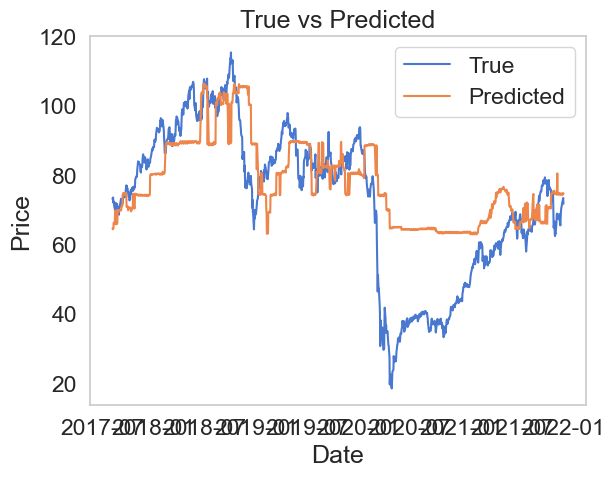

In [132]:
plt.plot(y_pred_df['Date'], y_pred_df['Price'], label='True')
plt.plot(y_pred_df['Date'], y_pred_df['PredictedPrice'], label='Predicted')
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# 4)
## Baseline (1 lag)

Let's see how a model would perform if we just guessed the price of the previous day.

In [ ]:
naive_train = y_train.shift(1)
naive_test = y_test.shift(1)

# calculate MAPE
naive_train_mape = MAPE_squared(y_train, naive_train)
naive_test_mape = MAPE_squared(y_test, naive_test)

print("Naive Train MAPE: ", naive_train_mape)
print("Naive Test MAPE: ", naive_test_mape)

Naive Train MAPE:  0.0005474089120760684
Naive Test MAPE:  0.0010446314501293768


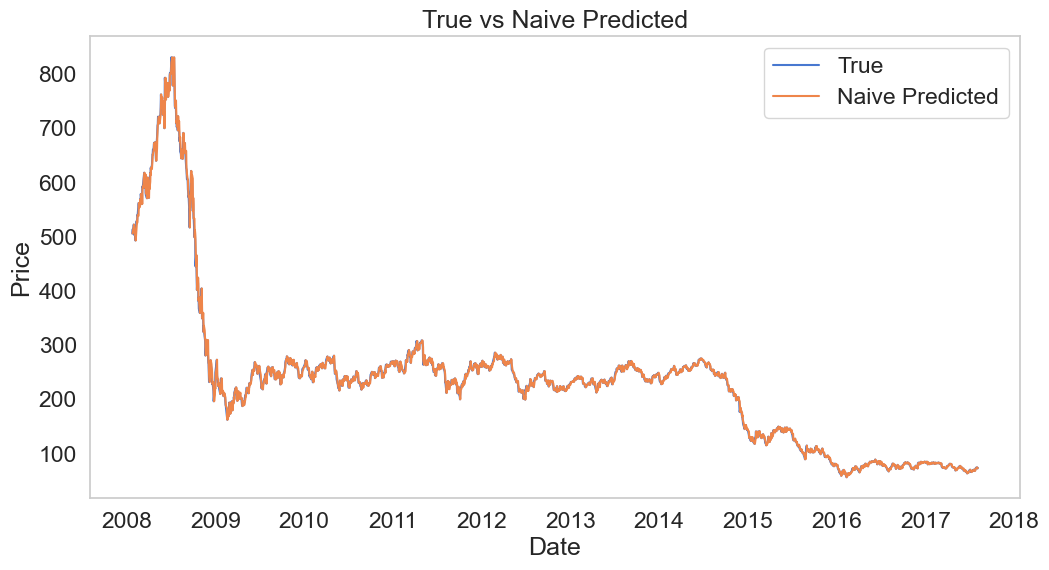

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(training_df['Date'], training_df['Price'], label='True')
plt.plot(training_df['Date'], naive_train, label='Naive Predicted')
plt.title('True vs Naive Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

Text(0.5, 1.0, 'True vs Naive Predicted')

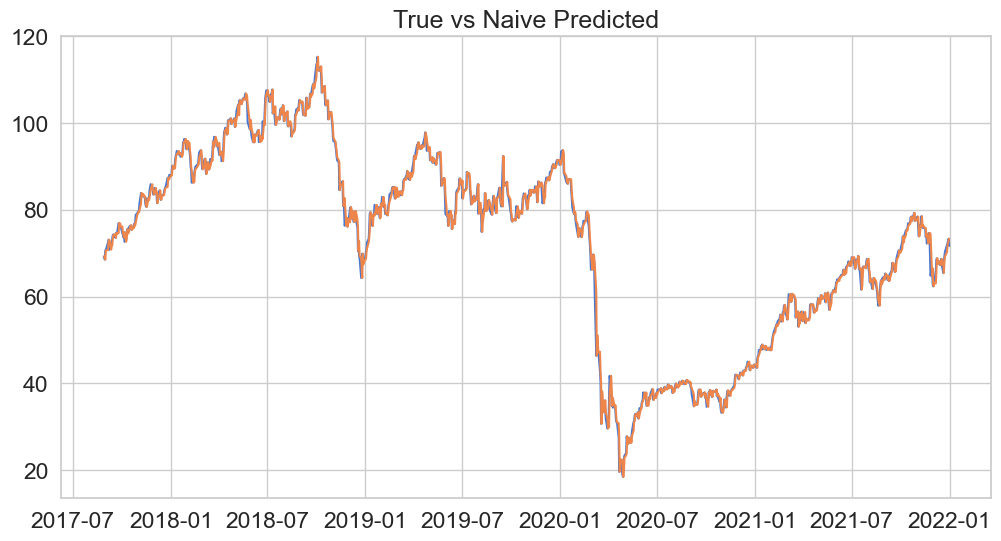

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_df['Price'], label='True')
plt.plot(test_df['Date'], naive_test, label='Naive Predicted')
plt.title('True vs Naive Predicted')

# 5)
## ARIMA

/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsm

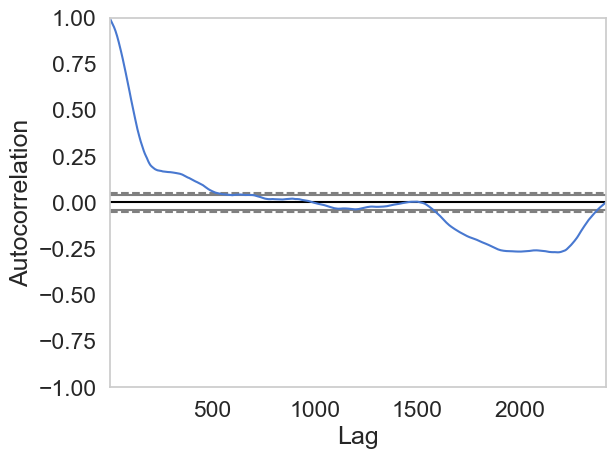

In [171]:
# train ARIMA model with different params
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

# we start with Jan 2, 2008
# training set ends at Aug 4, 2017
training_df = df[(df['Date'] <= '2017-08-04') & (df['Date'] >= '2008-01-02')]
test_df = df[df['Date'] > '2017-08-04']


autocorrelation_plot(training_df['Price'])

ARIMA_model = ARIMA(training_df['Price'], order=(20, 1, 5))

# get MAPE from training
res = ARIMA_model.fit()

In [199]:
training_df['Price']

19      562.0380
20      559.8310
21      552.7590
22      536.9720
23      543.6490
          ...   
2433     74.4137
2434     72.9157
2435     73.5534
2436     72.7228
2437     73.5386
Name: Price, Length: 2419, dtype: float64

In [ ]:
# import deepcopy
from copy import deepcopy

def forecast_test(model, training_df, test_df, steps=1):
    model = deepcopy(model)
    # reset model history to steps - 1
    if steps == 1:
        history = training_df['Price']
    else:
        history = training_df['Price'].iloc[:-steps + 1]
    model = model.apply(history, refit=False)
    # training prices to include
    if steps == 1:
        training_prices_for_test = []
    else:
        training_prices_for_test = training_df['Price'].iloc[-steps + 1:].values
    test_prices_to_include = test_df['Price'].iloc[:-steps].values

    all_prices = np.concatenate([training_prices_for_test, test_prices_to_include])

    predictions = []
    for actual in tqdm.tqdm(all_prices):
        # 3a. forecast t+1
        yhat = model.forecast(steps=steps).iloc[-1]
        predictions.append(yhat)
        
        # 3b. update the state with the true observation
        #     refit=False means params stay fixed
        model = model.append(endog=[actual], refit=False)

    return np.array(predictions), steps - 1


pred, starting_index = forecast_test(res, training_df, test_df, steps=1)

/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


History:  19      562.0380
20      559.8310
21      552.7590
22      536.9720
23      543.6490
          ...   
2433     74.4137
2434     72.9157
2435     73.5534
2436     72.7228
2437     73.5386
Name: Price, Length: 2419, dtype: float64


  0%|          | 0/1110 [00:00<?, ?it/s]/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results wi

KeyboardInterrupt: 

Text(0.5, 1.0, 'True vs Predicted')

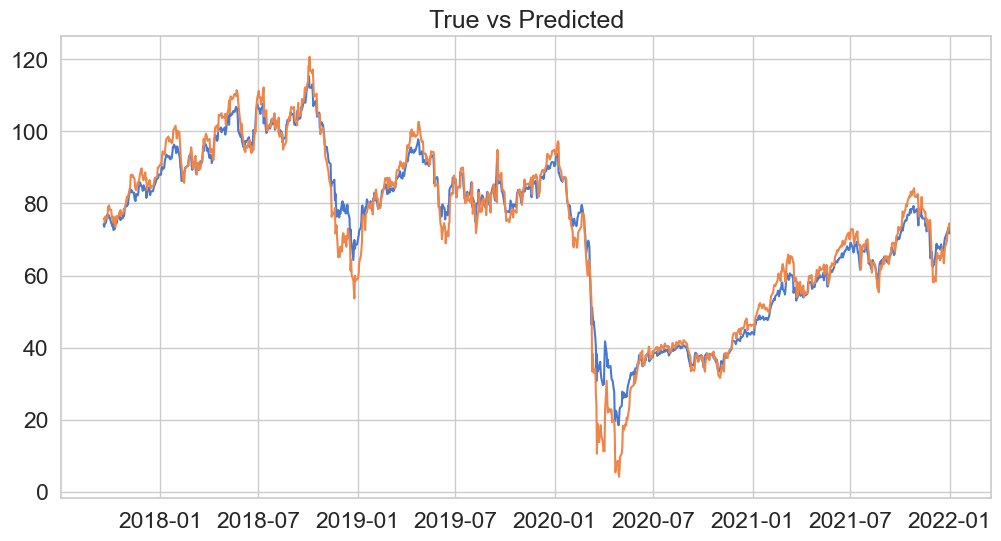

In [184]:
# plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'].iloc[starting_index:], test_df['Price'].iloc[starting_index:], label='True')
plt.plot(test_df['Date'].iloc[starting_index:], pred[starting_index:], label='Predicted')
plt.title('True vs Predicted')